Epoch 1, Loss: 0.0794
Epoch 2, Loss: 0.0438
Epoch 3, Loss: 0.0397
Epoch 4, Loss: 0.0378
Epoch 5, Loss: 0.0364
Epoch 6, Loss: 0.0356
Epoch 7, Loss: 0.0346
Epoch 8, Loss: 0.0342
Epoch 9, Loss: 0.0338
Epoch 10, Loss: 0.0335
Epoch 11, Loss: 0.0330
Epoch 12, Loss: 0.0331
Epoch 13, Loss: 0.0331
Epoch 14, Loss: 0.0325
Epoch 15, Loss: 0.0324
Epoch 16, Loss: 0.0329
Epoch 17, Loss: 0.0324
Epoch 18, Loss: 0.0319
Epoch 19, Loss: 0.0322
Epoch 20, Loss: 0.0323
Epoch 21, Loss: 0.0314
Epoch 22, Loss: 0.0319
Epoch 23, Loss: 0.0316
Epoch 24, Loss: 0.0317
Epoch 25, Loss: 0.0313
Epoch 26, Loss: 0.0311
Epoch 27, Loss: 0.0313
Epoch 28, Loss: 0.0314
Epoch 29, Loss: 0.0311
Epoch 30, Loss: 0.0311
Epoch 31, Loss: 0.0313
Epoch 32, Loss: 0.0310
Epoch 33, Loss: 0.0308
Epoch 34, Loss: 0.0312
Epoch 35, Loss: 0.0311
Epoch 36, Loss: 0.0309
Epoch 37, Loss: 0.0307
Epoch 38, Loss: 0.0312
Epoch 39, Loss: 0.0306
Epoch 40, Loss: 0.0309


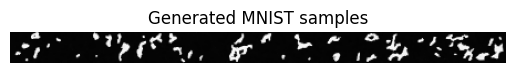

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os

# --- U-Net-like model for DDPM ---
class SimpleUNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(2, 64, 3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 1, 3, padding=1)
        )

    def forward(self, x, t):
        t_embed = t[:, None, None, None].float() / 1000.0
        t_embed = t_embed.expand_as(x)
        x = torch.cat([x, t_embed], dim=1)
        return self.net(x)

# --- Forward diffusion process ---
def q_sample(x_0, t, noise, alphas_bar):
    return torch.sqrt(alphas_bar[t])[:, None, None, None] * x_0 + \
           torch.sqrt(1 - alphas_bar[t])[:, None, None, None] * noise

# --- Training function ---
def train_ddpm(model, dataloader, optimizer, alphas_bar, device):
    model.train()
    total_loss = 0
    for x, _ in dataloader:
        x = x.to(device)
        noise = torch.randn_like(x)
        t = torch.randint(0, 1000, (x.size(0),), device=device)
        x_t = q_sample(x, t, noise, alphas_bar)
            
        optimizer.zero_grad()
        noise_pred = model(x_t, t)
        loss = F.mse_loss(noise_pred, noise)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

# --- Sampling ---
def sample_ddpm(model, shape, alphas, alphas_bar, device):
    model.eval()
    x_t = torch.randn(shape).to(device)
    for t in reversed(range(1000)):
        t_tensor = torch.full((shape[0],), t, device=device)
        with torch.no_grad():
            noise_pred = model(x_t, t_tensor)
        alpha = alphas[t]
        alpha_bar = alphas_bar[t]
        if t > 0:
            noise = torch.randn_like(x_t)
        else:
            noise = torch.zeros_like(x_t)
        x_t = (1 / torch.sqrt(alpha)) * (x_t - (1 - alpha) / torch.sqrt(1 - alpha_bar) * noise_pred) + \
              torch.sqrt(1 - alpha) * noise
    return x_t

# --- Main script ---
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x * 2 - 1)
    ])

    dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
    dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

    T = 1000
    betas = torch.linspace(1e-4, 0.02, T)
    alphas = 1.0 - betas
    alphas_bar = torch.cumprod(alphas, dim=0).to(device)
    alphas = alphas.to(device)

    model = SimpleUNet().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    losses = []
    epochs = 40
    for epoch in range(epochs):
        loss=train_ddpm(model, dataloader, optimizer, alphas_bar, device)
        losses.append(loss)
        print(f"Epoch {epoch+1}, Loss: {loss:.4f}")
    samples = sample_ddpm(model, (16, 1, 28, 28), alphas, alphas_bar, device)
    samples = (samples + 1) / 2 

    grid = torch.cat([samples[i] for i in range(16)], dim=2).squeeze().cpu().numpy()
    plt.imshow(grid, cmap='gray')
    plt.axis('off')
    plt.title('Generated MNIST samples')
    plt.show()


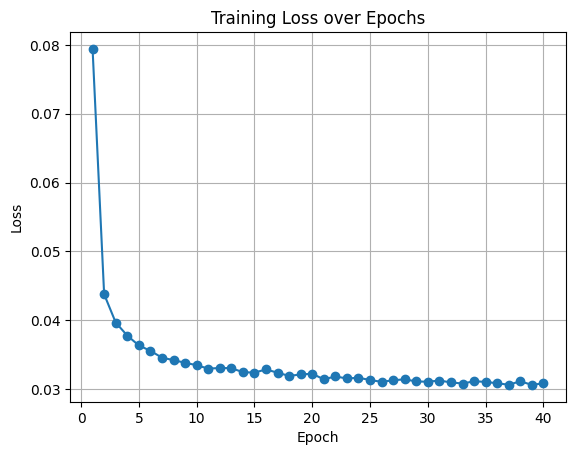

In [24]:
import matplotlib.pyplot as plt

plt.plot(range(1, epochs+1), losses, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss over Epochs")
plt.grid(True)
plt.show()

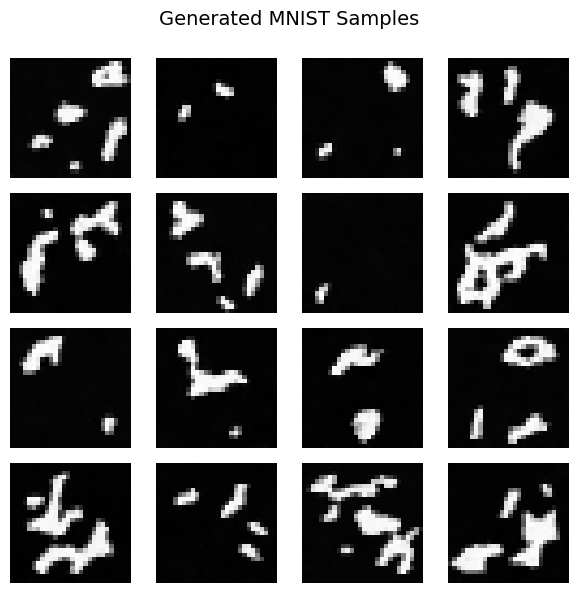

In [25]:
import matplotlib.pyplot as plt

# Assume samples is a tensor of shape [N, 1, H, W], e.g., [16, 1, 28, 28]
plot_samples = samples[:16].squeeze(1).cpu().numpy()  # shape: [16, 28, 28]

fig, axes = plt.subplots(4, 4, figsize=(6, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(plot_samples[i], cmap='gray')
    ax.axis('off')

plt.suptitle('Generated MNIST Samples', fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Make room for title
plt.show()
